<a href="https://colab.research.google.com/github/q4quang/AIO-2024/blob/feature/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import các thư viện cần thiết


In [2]:
import pandas as pd

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
!pip install contractions
import contractions

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.3 MB/s eta 0:00:00


### 2. Đọc bộ dữ liệu


In [3]:
df = pd.read_csv('./data/IMDB-Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### 3. Preprocessing


In [6]:
# check for duplicates row
len(pd.unique(df['review']))

49582

In [7]:
# Remove duplicate rows
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [8]:
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()

    soup  = BeautifulSoup(text, 'html.parser') # Removing html tags
    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
    emoji_clean = re.compile("["
                              u"\U0001F600-\U0001F64F" # emoticons
                              u"\U0001F300-\U0001F5FF" # symbols & pictographs
                              u"\U0001F680-\U0001F6FF" # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text) # add space after full stop
    text = re.sub(r'http\S+', '', text) # remove urls
    text = ''.join([
        word.lower() for word in text if word not in string.punctuation
    ]) # remove punctuation and make text lowercase
    text = ' '.join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
    ]) # lemmatize
    return text

df['review'] = df['review'].apply(preprocess_text)
df['review']

<ipython-input-8-35613e8ec19c>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup  = BeautifulSoup(text, 'html.parser') # Removing html tags


,review
0,one reviewer mentioned watching oz episode hoo...
1,wonderful little production filming technique ...
2,thought wonderful way spend time hot summer we...
3,basically family little boy jake think zombie ...
4,petter matteis love time money visually stunni...
...,...
49995,thought movie right good job creative original...
49996,bad plot bad dialogue bad acting idiotic direc...
49997,catholic taught parochial elementary school nu...
49998,going disagree previous comment side maltin on...


### 4. Phân tích dữ liệu

- thống kê số lượng các nhãn trong dữ liệu


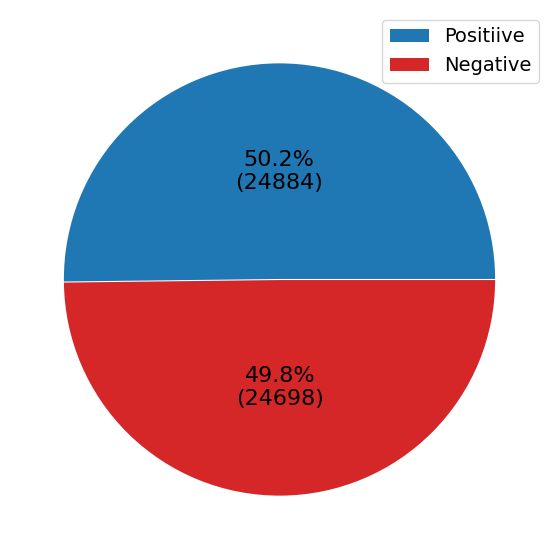

In [9]:
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']
# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2,
        pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'],
        textprops={'fontsize': 16})
# plt.title(’Frequencies of sentiment labels’, fontsize=14, fontweight=’bold’)
labels = [r'Positiive', r'Negative']
plt.legend(labels, loc='best', prop={'size': 14})
pie.savefig('PieChart.png')
plt.show()

In [10]:
np.unique(df['review'].str.split().to_numpy())

array([list(['aaa', 'favorite', 'movie', 'seen', 'number', 'time', 'remember', 'count', 'every', 'time', 'love', 'best', 'movie', 'raj', 'kumar', 'santoshi', 'comedy', 'dialogue', 'performance', 'amazing', 'actor', 'actress', 'done', 'superb', 'job', 'cannot', 'stop', 'laughing', 'watching', 'movie', 'hilarious', 'amir', 'khan', 'salman', 'khan', 'done', 'great', 'job', 'acting', 'paresh', 'rawal', 'excellent', 'always', 'music', 'inspired', 'old', 'hindi', 'movie', 'music', 'good', 'entire', 'cast', 'movie', 'done', 'great', 'job', 'overall', 'great', 'indian', 'comedy', 'movie', 'watch']),
       list(['aaaaaaaaaaaahhhhhhhhhhhhhh', 'hurting', 'stop', 'said', 'somewhere', 'beginning', 'part', 'movie', 'really', 'sucked', 'film', 'nearly', 'sapped', 'life', 'sat', 'really', 'bad', 'movie', 'coming', 'true', 'puppet', 'master', 'fan', 'would', 'expect', 'hear', 'say', 'true', 'plot', 'inane', 'special', 'effect', 'awful', 'sound', 'track', 'benawl', 'infernal', 'tootling', 'ever', 'hear

In [11]:
unique_vocab = np.unique(np.concatenate(df['review'].str.split().to_numpy()))

In [12]:
len(unique_vocab)

143180

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


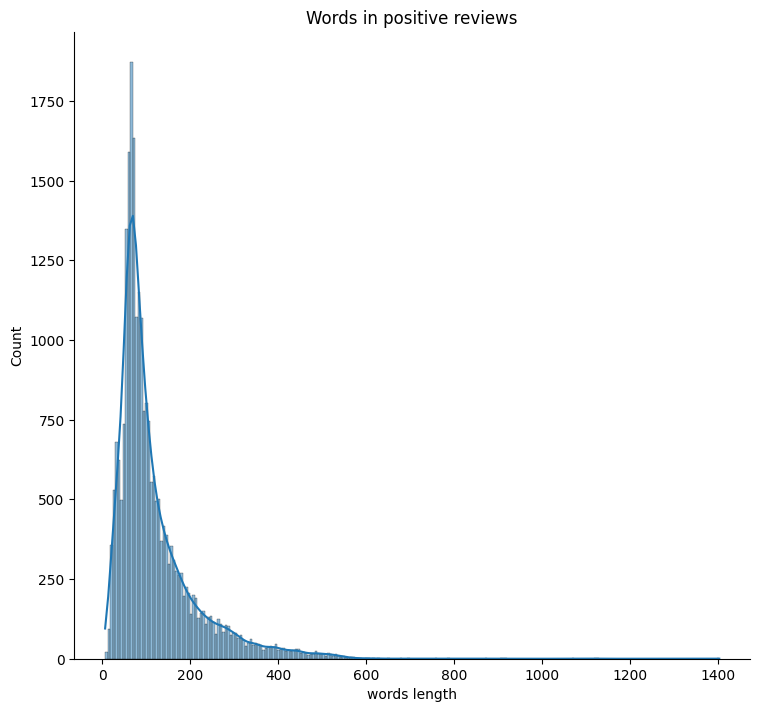

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


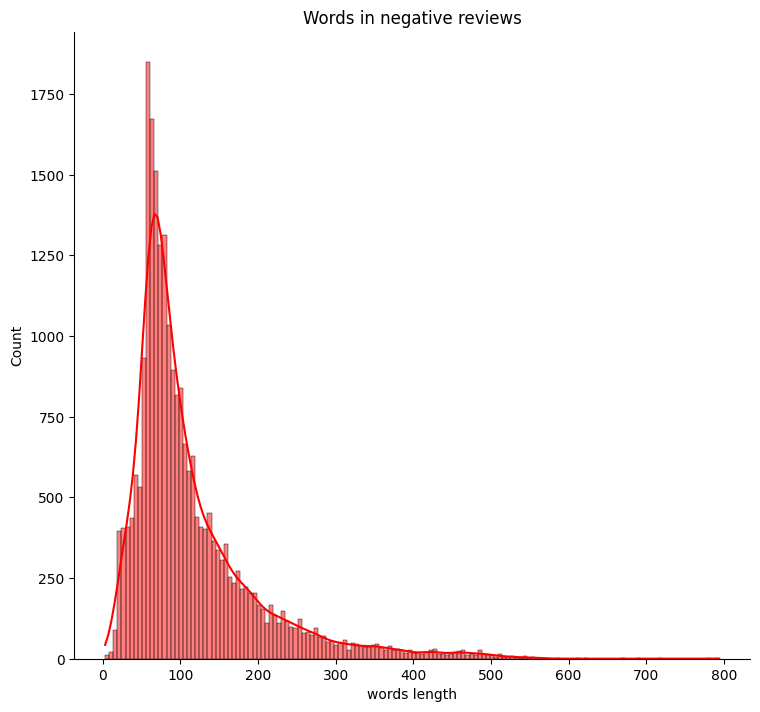

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


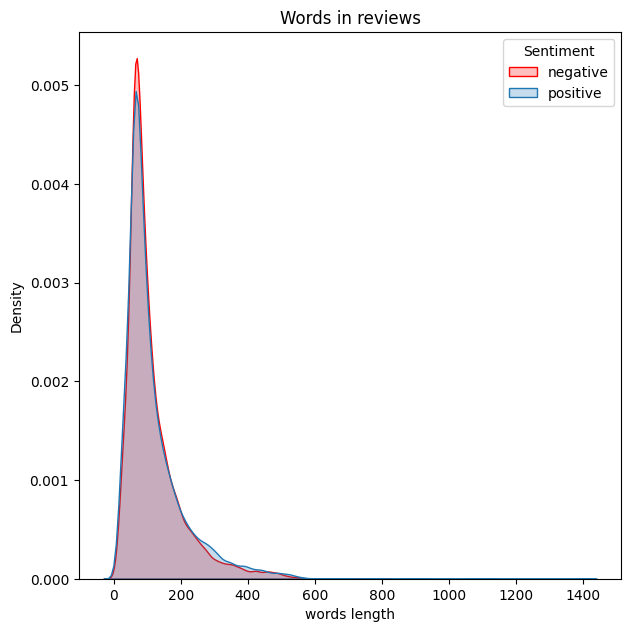

In [13]:
# Thống kê độ dài của các mẫu cho mỗi class
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x='words length', hue='sentiment', kde=True, height=7,
    aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x='words length', hue='sentiment', kde=True, height=7,
    aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x='words length', hue='sentiment', fill=True,
    palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distribution_number_words_plot)

### 5. Chia tập train và test


In [14]:
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])
x_data = df['review']

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

### 6. Biểu diễn văn bản thành vector


In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

### 7. Huấn luyện và đánh giá mô hình


##### Decision Tree Classifier


In [16]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7180598971463145

##### Random Forest Classifier


In [17]:
rf_classifier = RandomForestClassifier(
    random_state=42
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8420893415347384

##### AdaBoost

In [18]:
adaBoost_classifier = AdaBoostClassifier(random_state=42)
adaBoost_classifier.fit(x_train_encoded, y_train)
y_pred = adaBoost_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7930825854593123

##### Gradient Boost

In [19]:
gradient_boost_classifier = GradientBoostingClassifier(criterion='squared_error', random_state=42)
gradient_boost_classifier.fit(x_train_encoded, y_train)
y_pred = gradient_boost_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7967127155389735

##### XGBoost

In [20]:
from xgboost import XGBClassifier

xgboost_classifier = XGBClassifier()
xgboost_classifier.fit(x_train_encoded, y_train)
y_pred = xgboost_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8490470908540889